In [1]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pickle
import copy

from uncertainty_forest.uncertainty_forest import UncertaintyForest
from sklearn.ensemble import RandomForestClassifier
from sklearn.calibration import CalibratedClassifierCV

from tqdm.notebook import tqdm
from joblib import Parallel, delayed
from scipy.stats import entropy, multivariate_normal
from scipy.integrate import nquad

/Users/ronak/miniconda3/envs/mgc/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
import os,sys,inspect
current_dir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parent_dir = os.path.dirname(current_dir)
sys.path.insert(0, parent_dir) 
import mixed

In [3]:
from sklearn.model_selection import train_test_split
from sklearn import tree
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

In [4]:
def uf(X, y, n_estimators = 300, max_samples = .4, base = np.exp(1), kappa = 3):
    
    # Build forest with default parameters.
    model = BaggingClassifier(DecisionTreeClassifier(), 
                              n_estimators=n_estimators, 
                              max_samples=max_samples, 
                              bootstrap=False)
    model.fit(X, y)
    n = X.shape[0]
    K = model.n_classes_
    
    for tree_idx, tree in enumerate(model):
        
        # Find the indices of the training set used for partition.
        sampled_indices = model.estimators_samples_[tree_idx]
        unsampled_indices = np.delete(np.arange(0,n), sampled_indices)
        
        # Randomly split the rest into voting and evaluation.
        total_unsampled = len(unsampled_indices)
        np.random.shuffle(unsampled_indices)
        vote_indices = unsampled_indices[:total_unsampled//2]
        eval_indices = unsampled_indices[total_unsampled//2:]
        
        # Store the posterior in a num_nodes-by-num_classes matrix.
        # Posteriors in non-leaf cells will be zero everywhere
        # and later changed to uniform.
        node_counts = tree.tree_.n_node_samples
        class_counts = np.zeros((len(node_counts), K))
        for vote_index in vote_indices:
            class_counts[tree.apply(X[vote_index].reshape(1, -1)).item(), y[vote_index]] += 1
        row_sums = class_counts.sum(axis=1) # Total number of estimation points in each leaf.
        row_sums[row_sums == 0] = 1 # Avoid divide by zero.
        class_probs = class_counts / row_sums[:, None]
        
        # Make the nodes that have no estimation indices uniform.
        # This includes non-leaf nodes, but that will not affect the estimate.
        where_empty = np.argwhere(class_probs.sum(axis = 1) == 0)
        for elem in where_empty:
            class_probs[elem] = [1 / K]*K
        
        # Apply finite sample correction and renormalize.
        where_0 = np.argwhere(class_probs == 0)
        for elem in where_0:
            class_probs[elem[0], elem[1]] = 1 / (kappa*class_counts.sum(axis = 1)[elem[0]])
        row_sums = class_probs.sum(axis=1)
        class_probs = class_probs / row_sums[:, None]
        
        # Place evaluation points in their corresponding leaf node.
        # Store evaluation posterior in a num_eval-by-num_class matrix.
        eval_class_probs = [class_probs[x] for x in tree.apply(X[eval_indices])]
        eval_entropies = [entropy(posterior) for posterior in eval_class_probs]
        cond_entropy = np.mean(eval_entropies)
        
        return cond_entropy

In [5]:
def generate_data(n, d, mu = 1, var1 = 1, three_class = False):
    
    means, Sigma, probs = _make_params(d, mu = mu, var1 = var1, three_class = three_class)
    counts = np.random.multinomial(n, probs, size = 1)[0]
    
    X_data = []
    y_data = []
    for k in range(len(probs)):
        X_data.append(np.random.multivariate_normal(means[k], Sigma, counts[k]))
        y_data.append(np.repeat(k, counts[k]))
    X = np.concatenate(tuple(X_data))
    y = np.concatenate(tuple(y_data))
    
    return X, y

def _make_params(d, mu = 1, var1 = 1, three_class = False):
    
    if three_class:
        return _make_three_class_params(d, mu)
    
    mean = np.zeros(d)
    mean[0] = mu
    means = [mean, -mean]
    Sigma = np.eye(d)
    Sigma[0, 0] = var1
    probs = [0.5, 0.5]
    
    return means, Sigma, probs

def _make_three_class_params(d, mu):
    
    means = []
    mean = np.zeros(d)
    
    mean[0] = mu
    means.append(copy.deepcopy(mean))
    
    mean[0] = -mu
    means.append(copy.deepcopy(mean))
    
    mean[0] = 0
    mean[d-1] = mu
    means.append(copy.deepcopy(mean))
    
    Sigma = np.eye(d)
    probs = [1/3.]*3
    
    return means, Sigma, probs

In [6]:
def plot_setting(n, setting, ax):
    
    mean = 3 if setting['name'] == 'Three Class Gaussians' else 1
    X, y = generate_data(n, 2, **setting['kwargs'], mu = mean)
        
    colors = ["#c51b7d", "#2166ac", "#d95f02"]
    ax.scatter(X[:, 0], X[:, 1], color = np.array(colors)[y], marker = ".")
    
    ax.set_xlim(left = -5.05)
    ax.set_xlim(right = 5.05)
    
    ax.set_ylabel(setting['name'])

In [7]:
# Setting figures.
settings = [
    {
        'name' : 'Sphereical Gaussians',
        'kwargs': {},
        'filename' : 'spherical'
    },
    {
        'name' : 'Elliptical Gaussians',
        'kwargs': {'var1' : 3},
        'filename' : 'ellyptical'
    },
    {
        'name' : 'Three Class Gaussians',
        'kwargs': {'three_class' : True},
        'filename' : 'three_class'
    },
]

In [8]:
def compute_mutual_info(d, base = np.exp(1), mu = 1, var1 = 1, three_class = False):
    
    if d > 1:
        dim = 2
    else:
        dim = d
 
    means, Sigma, probs = _make_params(dim, mu = mu, var1 = var1, three_class = three_class)
    
    # Compute entropy and X and Y.
    def func(*args):
        x = np.array(args)
        p = 0
        for k in range(len(means)):
            p += probs[k] * multivariate_normal.pdf(x, means[k], Sigma)
        return -p * np.log(p) / np.log(base)

    scale = 10
    lims = [[-scale, scale]]*dim
    H_X, int_err = nquad(func, lims)
    H_Y = entropy(probs, base = base)
    
    # Compute MI.
    H_XY = (dim * np.log(2*np.pi) + np.log(np.linalg.det(Sigma)) + dim) / (2 * np.log(base))
    I_XY = H_X - H_XY
    
    return I_XY, H_X, H_Y

In [9]:
def estimate_mi(X, y, label):
    
    _, counts = np.unique(y, return_counts=True)
    est_H_Y = entropy(counts, base=np.exp(1))
    
    if label == "IRF":
        frac_eval = 0.3
        irf = CalibratedClassifierCV(base_estimator=RandomForestClassifier(n_estimators = 300), 
                                     method='isotonic', 
                                     cv = 5)
        # X_train, y_train, X_eval, y_eval = split_train_eval(X, y, frac_eval)
        X_train, X_eval, y_train, y_eval = train_test_split(X, y, test_size=frac_eval)
        irf.fit(X_train, y_train)
        p = irf.predict_proba(X_eval)
        return est_H_Y - np.mean(entropy(p.T, base = np.exp(1)))
    elif label == "UF":
        return est_H_Y - uf(np.array(X), y)
    elif label == "KSG":
        return mixed.KSG(X, y.reshape(-1, 1)) 
    elif label == "Mixed KSG":
        return mixed.Mixed_KSG(X, y.reshape(-1, 1))
    else:
        raise ValueError("Unrecognized Label!")

In [10]:
# Determine what the upper and lower bounds are for binary search.
def bounds_for_conv(label, X_full, y_full, I_XY, alpha, n, num_trials):

    if n >= len(X_full):
        return n, n
    
    # By what factor to increase n when checking for the next one.
    scale = 2
    
    rel_err = compute_rel_err(X_full, y_full, label, I_XY, n, num_trials)
    if rel_err > alpha:
        return bounds_for_conv(label, X_full, y_full, I_XY, alpha, n * scale, num_trials)
    else:
        return n // scale, n
    
def compute_rel_err(X_full, y_full, label, I_XY, n, num_trials):
    err = 0
    for t in range(num_trials):
        indices = np.random.choice(np.arange(len(X_full)), size=n, replace=False)
        X = X_full[indices,:]
        y = y_full[indices]
        mi_est = estimate_mi(X, y, label)
        err += np.abs(mi_est - I_XY) / I_XY
    err /= num_trials
    return err
    
def binary_search(label, X_full, y_full, I_XY, alpha, lower, upper, num_trials):
    precision = 5
    
    start = lower
    end = upper
    mid = (start + end) // 2
    prev_mid = -1000000
    
    rel_err = compute_rel_err(X_full, y_full, label, I_XY, mid, num_trials)    
    while np.abs(prev_mid - mid) > precision:
        prev_mid = mid
        if rel_err > alpha:
            start = mid
        else:
            end = mid
        mid = (start + end) // 2

        rel_err = compute_rel_err(X_full, y_full, label, I_XY, mid, num_trials)
    return mid

def num_samples_to_conv(label, X_full, y_full, I_XY, alpha, num_trials):
    # Find numbers lower and higher than the number required for convergence.
    n_min = 200
    lower, upper = bounds_for_conv(label, X_full, y_full, I_XY, alpha, n_min, num_trials)
    if upper == lower:
        return upper
    
    # Search for the number between them for which it converges.
    return binary_search(label, X_full, y_full, I_XY, alpha, lower, upper, num_trials)

In [11]:
def get_mutual_info_vs_d(ds, algos, num_trials, setting, alpha, n_max, base = np.exp(1)):
    for algo in algos:
        print("Determining required samples for %s." % algo['title'])
        output = np.zeros(len(ds))
        for i, d in enumerate(ds):
            X_full, y_full = generate_data(n_max, d, **setting['kwargs'])
            I_XY, H_X, H_Y = compute_mutual_info(d, **setting['kwargs'])
            
            output[i] = num_samples_to_conv(algo['label'], X_full, y_full, I_XY, alpha, num_trials)
        
        pickle.dump(output, open('%s_by_d_%s.pkl' % (algo['label'], setting['filename']), 'wb'))
    pickle.dump(ds, open('ds.pkl', 'wb'))

In [12]:
# Real params.
num_trials = 20
alpha = 0.1
ds = range(1, 21)
n_max = 6000

# Fake params.
# num_trials = 3
# alpha = 0.3
# ds = range(1, 4)
# n_max = 4000

# Algorithms.
algos = [
    {
        'label': 'UF',
        'title': 'Uncertainty Forest',
        'color': "#F41711",
    },
#     {
#         'label': 'KSG',
#         'title': 'KSG',
#         'color': "#1b9e77",
#     },
#     {
#         'label': 'Mixed KSG',
#         'title': 'Mixed KSG',
#         'color': "purple",
#     },
    {
        'label': 'IRF',
        'title': 'Isotonic Reg. Forest',
        'color': "#fdae61",
    },
]

In [13]:
for setting in settings:
    get_mutual_info_vs_d(ds, algos, num_trials, setting, alpha, n_max)

Determining required samples for Uncertainty Forest.
Determining required samples for KSG.
Determining required samples for Mixed KSG.
Determining required samples for Isotonic Reg. Forest.
Determining required samples for Uncertainty Forest.
Determining required samples for KSG.
Determining required samples for Mixed KSG.
Determining required samples for Isotonic Reg. Forest.
Determining required samples for Uncertainty Forest.
Determining required samples for KSG.
Determining required samples for Mixed KSG.
Determining required samples for Isotonic Reg. Forest.


/Users/ronak/miniconda3/envs/mgc/lib/python3.7/site-packages/sklearn/calibration.py:394: RuntimeWarning: invalid value encountered in true_divide
  proba /= np.sum(proba, axis=1)[:, np.newaxis]


In [14]:
def plot_mutual_info_by_d(ds, setting, algos, ax):
    
    ds = pickle.load(open('ds.pkl', 'rb'))
    for j, algo in enumerate(algos):
        # Plot the mean over trials as a solid line.
        result = pickle.load(open('%s_by_d_%s.pkl' % (algo['label'], setting['filename']), 'rb'))
        ax.plot(ds, 
                result, 
                label = algo['label'], 
                linewidth = 2, 
                color = algo['color'])

    ax.set_xlabel("Number of Dimensions")
    ax.set_ylabel("Sample Size")
    # ax.set_yscale("log")
    
    ax.set_xlim(left = .95)
    ax.set_xlim(right = np.max(ds) + 0.05)

In [15]:
def plot_fig4(ds, algos, settings, alpha):        
    sns.set(font_scale = 1.4)
    sns.set_style("ticks")
    plt.figure()
    plt.rcParams["font.family"] = "sans-serif"
    fig, axes = plt.subplots(len(settings), 2, figsize = (12,18))
        
    for s, setting in enumerate(settings):
        plot_setting(2000, setting, axes[s, 0])
        plot_mutual_info_by_d(ds, setting, algos, axes[s, 1])

    axes[len(settings)-1, 1].legend(loc = 'lower right')
    axes[0, 1].set_title('Number of Samples until %d%% Error' % int(100*alpha), fontsize=16)
    axes[0, 0].set_title('Setting')
    plt.yticks(fontsize = 20)
    plt.xticks(fontsize = 20)
    plt.tight_layout()
    plt.savefig("fig4.pdf")
    plt.show()

<Figure size 432x288 with 0 Axes>

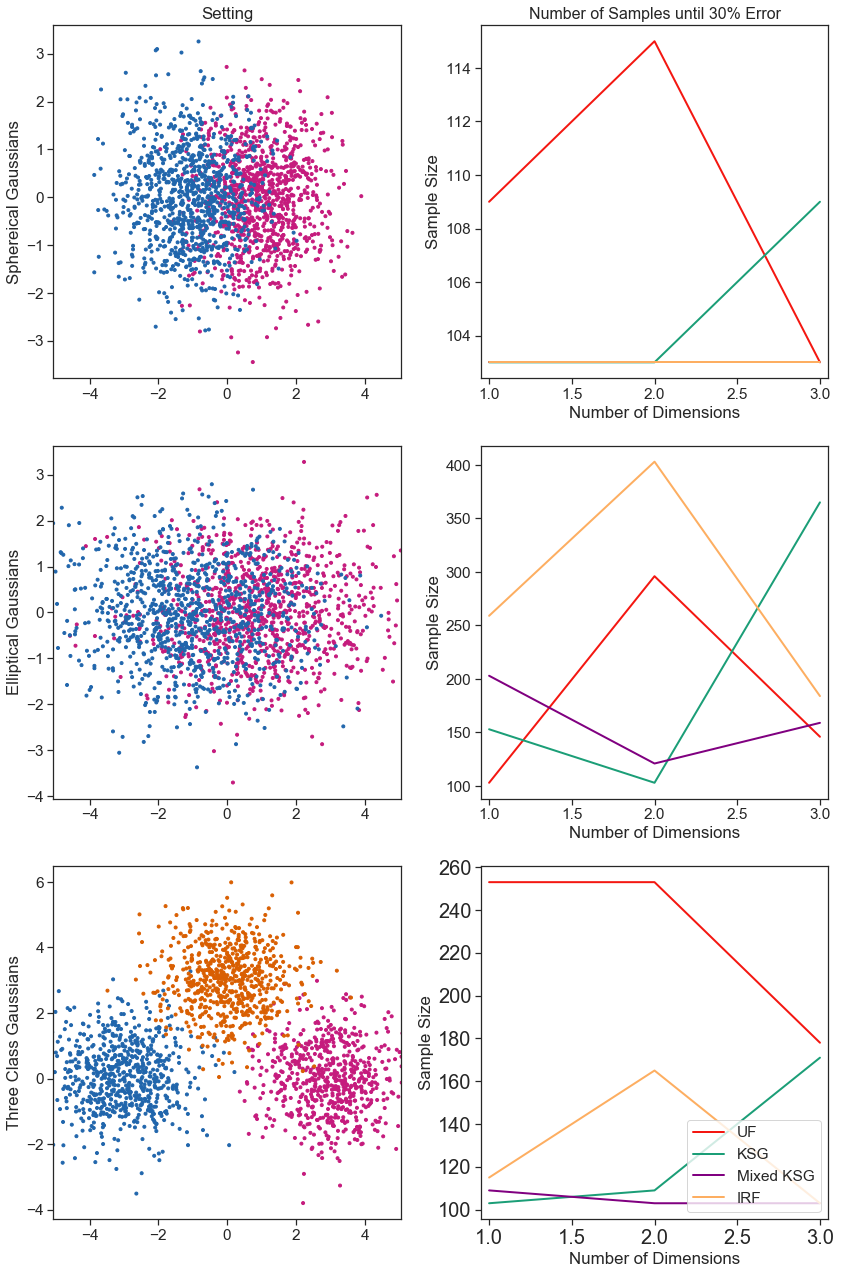

In [16]:
plot_fig4(ds, algos, settings, alpha)